## Forecasting U.S. natural gas prices

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
DATA_PATH = Path("./data/MHHNGSP.csv")

In [4]:
# FRED CSV usually has columns like: DATE, MHHNGSP
# Missing values may be "." → treat as NaN with na_values=["."]
df = pd.read_csv(
    DATA_PATH,
    parse_dates=["observation_date"],
    na_values=["."],
)

In [5]:
# Set index and rename the value column
df = df.rename(columns={"observation_date": "date", "MHHNGSP": "price"}).set_index("date").sort_index()

In [6]:
# Enforce monthly start-of-month frequency (MS) and drop any missing
y = df.asfreq("MS")["price"].astype(float)

In [7]:
print(y.head())
print(y.tail())
print(f"Observations: {y.notna().sum()}")

date
1997-01-01    3.45
1997-02-01    2.15
1997-03-01    1.89
1997-04-01    2.03
1997-05-01    2.25
Freq: MS, Name: price, dtype: float64
date
2025-06-01    3.02
2025-07-01    3.20
2025-08-01    2.91
2025-09-01    2.97
2025-10-01    3.19
Freq: MS, Name: price, dtype: float64
Observations: 346


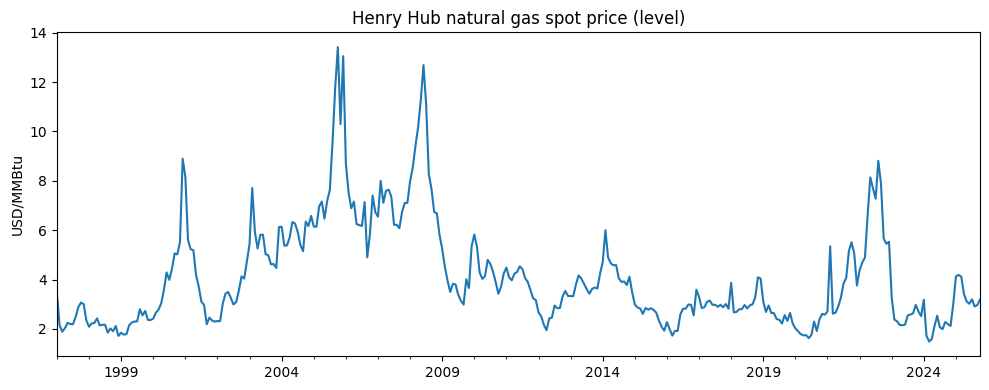

In [8]:
LOG = False  # set False if you prefer levels

series_to_plot = np.log(y) if LOG else y

ax = series_to_plot.plot(figsize=(10,4))
ax.set_title(f"Henry Hub natural gas spot price ({'log ' if LOG else ''}level)")
ax.set_ylabel("log USD/MMBtu" if LOG else "USD/MMBtu")
ax.set_xlabel("")
plt.tight_layout()
plt.show()

### Clean & validate the series

In [9]:
# Ensure numeric + drop missing created by asfreq
y = y.astype(float).dropna()


In [10]:
# Basic validation & sample info
n = len(y)
start, end = y.index.min().date(), y.index.max().date()
print(f"Sample: {start} → {end} | Observations: {n}")
assert n >= 100, "Need at least 100 observations."

Sample: 1997-01-01 → 2025-10-01 | Observations: 346


In [ ]:
# Check gaps
expected = pd.date_range(y.index.min(), y.index.max(), freq="MS")
missing = expected.difference(y.index)
print(f"Missing months: {len(missing)}")

Missing months: 0


### Define transformations you might use later

- Variable: Henry Hub natural gas spot price (USD/MMBtu), monthly, NSA.
- Transforms: log(p_t) (variance stabilization), Δlog(p_t) (stationarity, % changes).

In [12]:
LOG = True  # keep your switch

y_level = y.copy()
y_log = np.log(y_level)
y_dlog = y_log.diff().dropna()   # ≈ monthly % change


### Train/test split with last 20% as holdout

In [22]:
# Ensure y is your monthly series (MS) with float dtype, as in your code
n = len(y.dropna())
h_test = max(1, int(np.floor(0.20 * n)))  # 20% holdout
y_train = y.iloc[:-h_test]
y_test  = y.iloc[-h_test:]

print(f"Train: {y_train.index[0].date()} → {y_train.index[-1].date()}  (n={len(y_train)})")
print(f"Test : {y_test.index[0].date()} → {y_test.index[-1].date()}    (n={len(y_test)})")

Train: 1997-01-01 → 2020-01-01  (n=277)
Test : 2020-02-01 → 2025-10-01    (n=69)


### Plot log-level

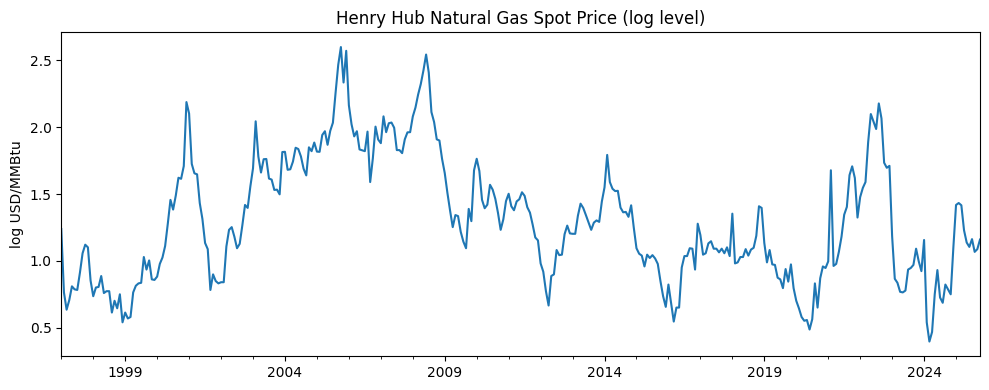

In [15]:
fig, ax = plt.subplots(figsize=(10,4))
y_log.plot(ax=ax)
ax.set_title("Henry Hub Natural Gas Spot Price (log level)")
ax.set_ylabel("log USD/MMBtu"); ax.set_xlabel("")
plt.tight_layout(); plt.show()

### Check seasonality (visual & ACF)

/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_72201/1204849273.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([z[month==m].values for m in range(1,13)], labels=[str(m) for m in range(1,13)])


<Figure size 900x400 with 0 Axes>

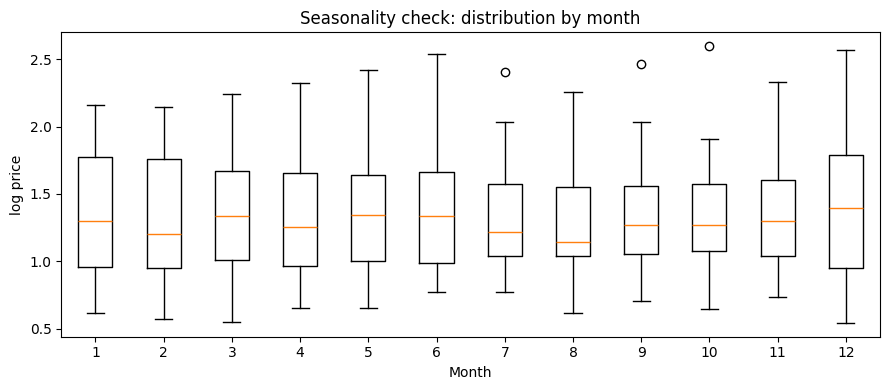

In [23]:
LOG = True
z = np.log(y_train) if LOG else y_train

# Seasonal boxplot by month
month = z.index.month
plt.figure(figsize=(9,4))
z.groupby(month).plot(kind="box")  # quick, but often messy; prefer explicit:
plt.clf()
fig, ax = plt.subplots(figsize=(9,4))
z.groupby(month).apply(list)
ax.boxplot([z[month==m].values for m in range(1,13)], labels=[str(m) for m in range(1,13)])
ax.set_title("Seasonality check: distribution by month")
ax.set_xlabel("Month")
ax.set_ylabel("log price" if LOG else "price")
plt.tight_layout()
plt.show()

In [24]:
from statsmodels.tsa.seasonal import STL

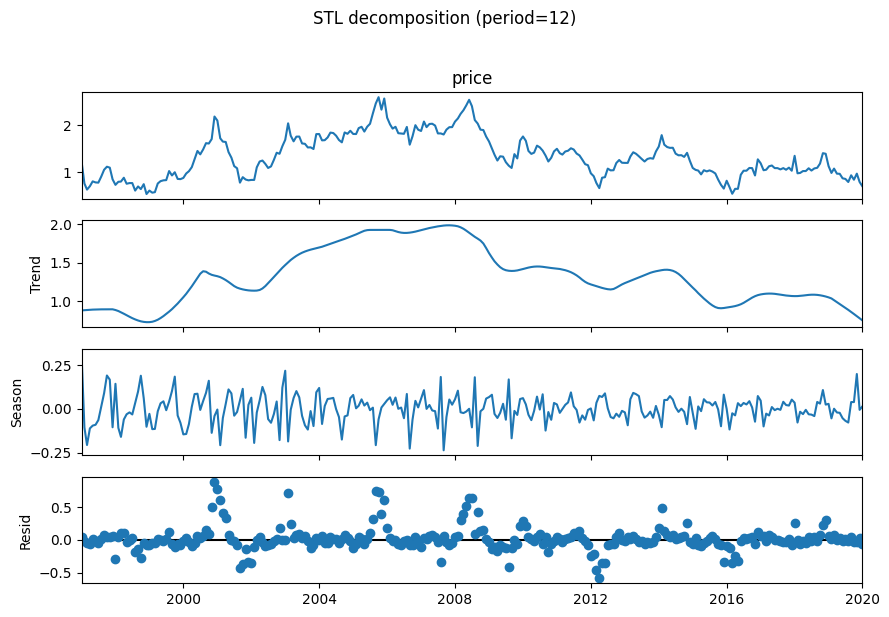

In [25]:
# STL decomposition (robust to outliers)
stl = STL(z, period=12, robust=True).fit()
fig = stl.plot()
fig.set_size_inches(9,6)
plt.suptitle("STL decomposition (period=12)", y=1.02)
plt.tight_layout()
plt.show()

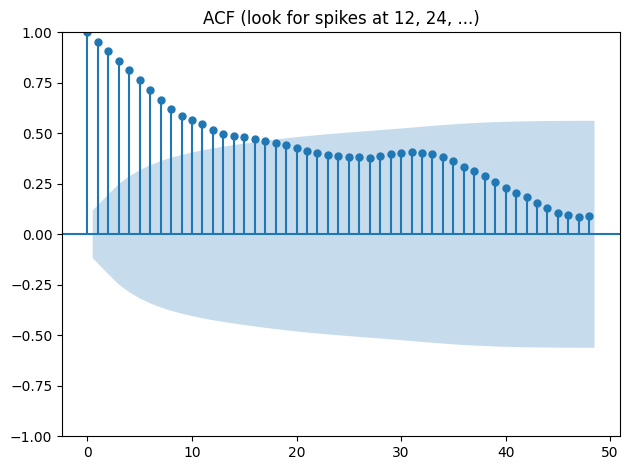

In [26]:
# ACF to see seasonal spikes at lag 12, 24, ...
fig = plot_acf(z.dropna(), lags=48)
plt.title("ACF (look for spikes at 12, 24, ...)")
plt.tight_layout()
plt.show()

Interpretation (what to look for):
- Monthly boxplot: different medians/levels across months → likely seasonality.
- STL: a clear 12-month repeating pattern in the seasonal component → seasonality present.
- ACF: prominent spikes at lags 12, 24, … → seasonal structure.

If these signals are weak or absent, treat the series as non-seasonal.

### Check stationarity (visual + ADF/KPSS)

Use two complementary tests:
- ADF (Augmented Dickey–Fuller): H₀ = unit root (non-stationary). Low p-value → reject non-stationary → stationary.
- KPSS: H₀ = stationary (around level or trend). Low p-value → reject stationary → non-stationary.

In [27]:
from statsmodels.tsa.stattools import adfuller, kpss

def run_adf(x):
    res = adfuller(x.dropna(), autolag="AIC")
    return {"stat": res[0], "pvalue": res[1]}

def run_kpss_test(x, regression="c"):
    # regression="c" tests level-stationarity; "ct" tests trend-stationarity
    stat, pval, lags, crit = kpss(x.dropna(), regression=regression, nlags="auto")
    return {"stat": stat, "pvalue": pval, "lags": lags}

X = z  # log or level as chosen above

print("Level/log series:")
print("  ADF :", run_adf(X))
print("  KPSS:", run_kpss_test(X, regression="c"))


Level/log series:
  ADF : {'stat': np.float64(-2.2588537452641915), 'pvalue': np.float64(0.18558190420333576)}
  KPSS: {'stat': np.float64(0.49852155015241567), 'pvalue': np.float64(0.04199965086657305), 'lags': 10}


The two tests tell us:
- ADF (p = 0.186) → you fail to reject the unit-root null. This points to non-stationarity in the current scale (level or log).
- KPSS level (“c”) (p = 0.042) → you reject level-stationarity at 5%. That also points to non-stationarity (i.e., the series is not stationary around a constant mean).

In its current form, this series is non-stationary. Both tests agree.
What this likely means
- The series probably has a stochastic trend (unit root).
- It might be stationary after differencing (and possibly after a seasonal difference if there’s a 12-month pattern).

Apply minimal differencing and retest:
1. Start with first difference
2. If you saw seasonal spikes at lag 12 in the ACF or STL, also try seasonal difference
3. Retest ADF & KPSS on each transformed series and pick the simplest one that looks stationary.